In [41]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from scipy.signal import argrelextrema, find_peaks
import pandas as pd

In [42]:
def sine_fit(x, y, trend=None, plot=True, p0=True):
    """Estimate parameters of a noisy sine wave by FFT and non-linear fitting."""
    
    # Define the sine function
    def sine_func(x, offs, amp, f, phi):
        return offs + amp * np.sin(2 * np.pi * f * x + phi)
    
    # Estimate frequency using FFT
    if trend is not None:
        y_ = y - trend
    else:
        y_ = y
    N = len(y_)
    f = np.linspace(0, 1, N)  # Frequency range
    yf = fft(y_)
    estimate_f = f[np.argmax(np.abs(yf[1:N//2]))]  # Exclude offset
    
    # Initial guess for the parameters
    guess = [np.mean(y_), np.std(y_), estimate_f, 0]
    
    # Perform the fit
    if p0:
        popt, pcov = curve_fit(sine_func, x, y_, p0=guess)
    else:
        popt, pcov = curve_fit(sine_func, x, y_)
    
    # Calculate mean squared error
    mse = np.mean((y_ - sine_func(x, *popt)) ** 2)
    
    # Append MSE to parameters
    popt = np.append(popt, mse)
    
    # Plot if requested
    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(x, y_,'o', 'b-', label='data')
        x = np.linspace(x[0], x[-1], 1000)
        plt.plot(x, sine_func(x, *popt[:-1]), 'r-', label='fit')
        plt.legend()
        plt.show()
    print(f'mse: {mse}')
    return popt

In [43]:
def get_linear_trend(x, y, smooth=True):
    if smooth:
        # Define window size for moving average
        window_size = 5

        # Compute moving averages
        smoothed_y = np.convolve(y, np.ones(window_size)/window_size, mode='same')

        y = smoothed_y

    # Calculate the linear trend
    slope, intercept = np.polyfit(x, y, 1)

    # Calculate the linear trend
    trend = slope * x + intercept

    return trend, slope, intercept

In [44]:
y = pd.read_csv('ccf_all.csv', header=None).to_numpy()
x = pd.read_csv('lags.csv', header=None).to_numpy().flatten()
ccf_mask = pd.read_csv('ccf_mask.csv', header=None).to_numpy()
ccf_fit_valid = pd.read_csv('ccf_fit_valid.csv', header=None).to_numpy()

ccf_mask = np.array(ccf_mask, dtype=bool).flatten()
ccf_fit_valid = np.array(ccf_fit_valid, dtype=bool).flatten()
valid = ccf_mask & ccf_fit_valid

y_valid = y[valid]
y_invalid = y[~valid]


In [45]:
import ipywidgets as widgets
from IPython.display import display

interactive(children=(IntSlider(value=0, description='index', max=544), FloatSlider(value=80.0, description='p…

<function __main__.plot_with_index(index, prominence_int, factor, sinefit=False, save_image=False)>

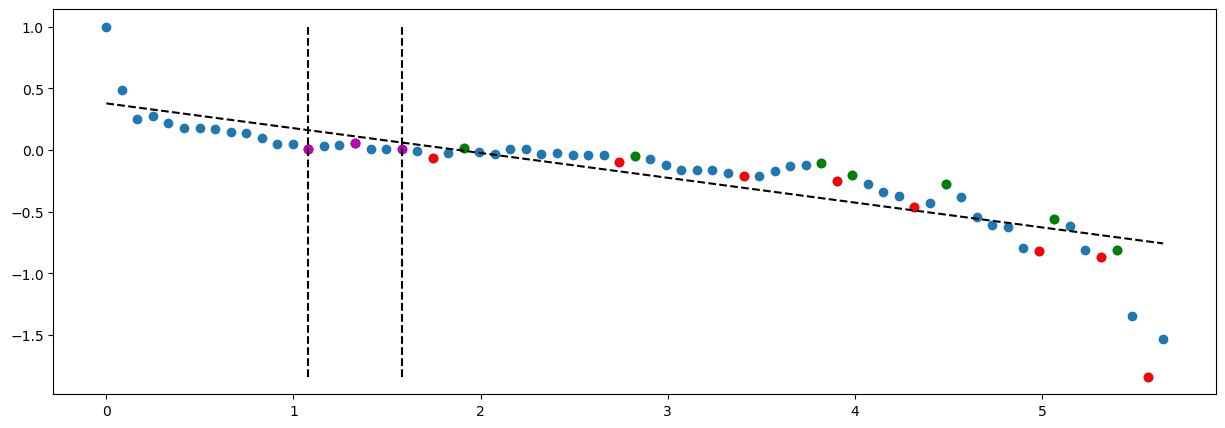

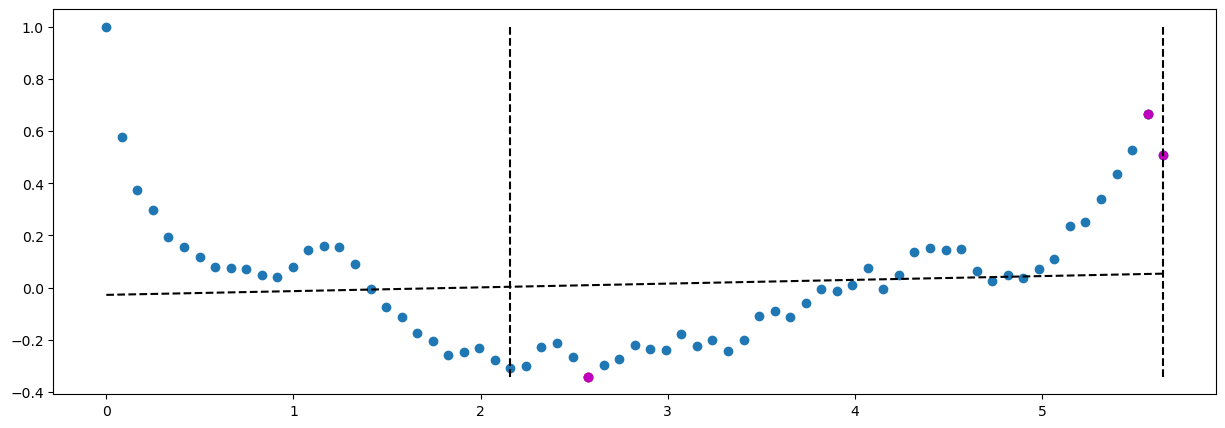

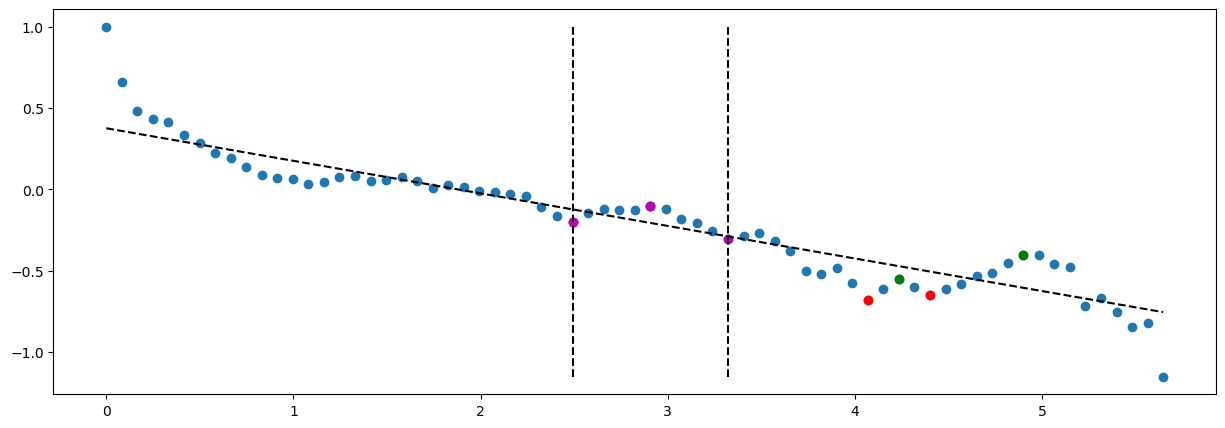

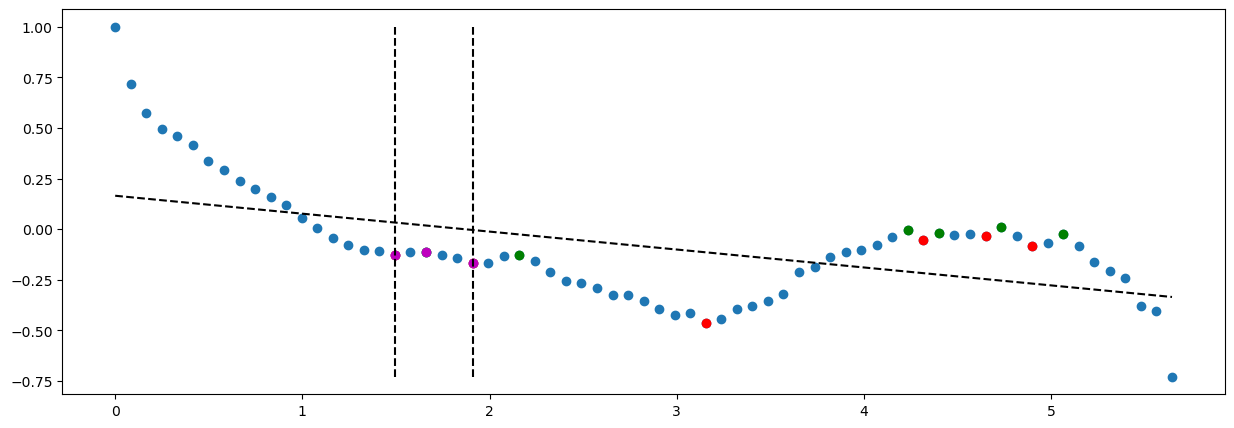

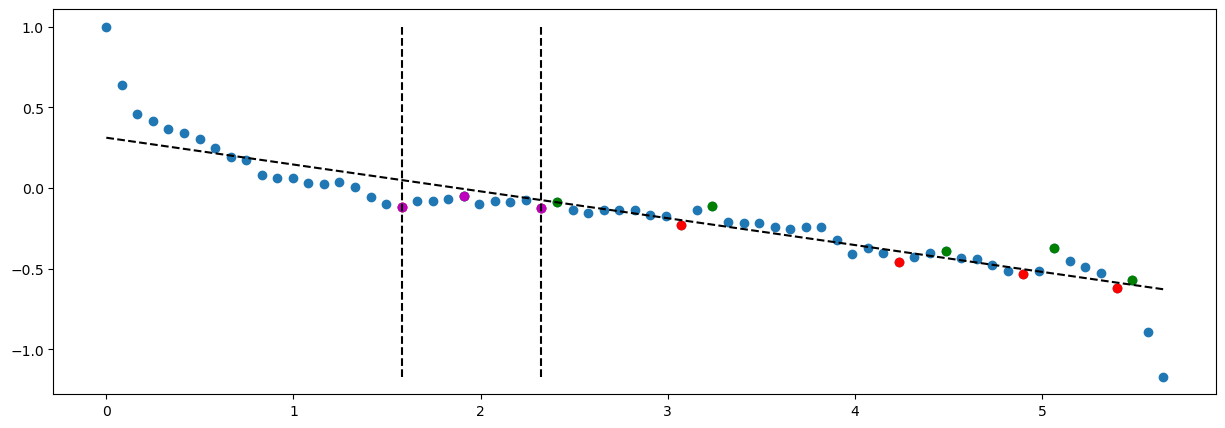

In [49]:

    
    
    
    
def plot_with_index(index,prominence_int, factor, sinefit=False, save_image=False):
    y = y_valid[index]

    prominence = np.percentile(y, prominence_int)
    def crop_around_extrema(x, y, prominence, factor, plot=True):
    
        # Find the indices of the minima and maxima in the dataset
        min_peak_idx, _ = find_peaks(-y, prominence=prominence)
        max_peak_idx, _ = find_peaks(y, prominence=prominence)

        # Raise an error if no prominent local extrema are found
        if len(min_peak_idx) == 0 or len(max_peak_idx) == 0:
            raise ValueError(f'no prominent local extrema for prominence {prominence} found')


        # Filter out maxima that occur before the first minimum
        max_peak_idx = max_peak_idx[max_peak_idx > min_peak_idx[0]] 

        # Initialize indices and values
        idx_1, idx_2, idx_3 = None, None, None
        val_1, val_2, val_3 = None, None, None

        # If there's only one minimum, set the indices and values accordingly
        if len(min_peak_idx) == 1:
            idx_1, idx_2 = min_peak_idx[0], max_peak_idx[0]
            val_1, val_2 = y[idx_1], y[idx_2]
            y_min = val_1    
            
            # determine new "maximum" position based on distance to the first minimum
            norm_tmp = np.linalg.norm([x[idx_2]-x[idx_1], val_2-val_1])            
            norm_right_tmp = [np.linalg.norm([x[idx+idx_2]-x[idx_2], val-y[idx_2]]) for idx, val in enumerate(y[idx_2:])]
            idx_3 = idx_2 + np.argmin(np.abs(np.array(norm_right_tmp)-norm_tmp))
            val_3 = y[idx_3]   
        else:
            # If there's more than one minimum, set the indices and values accordingly
            idx_1, idx_2, idx_3 = min_peak_idx[0], max_peak_idx[0], min_peak_idx[1]
            val_1, val_2, val_3 = y[idx_1], y[idx_2], y[idx_3]
            
        # If the distance between the second minimum and maximum is too large, ignore the second minimum
        if x[idx_3] - x[idx_2] > 1.5 * (x[idx_2] - x[idx_1]):
            y_min = val_1
            
            # determine new "maximum" position based on distance to the first minimum
            norm_tmp = np.linalg.norm([x[idx_2]-x[idx_1], val_2-val_1])            
            norm_right_tmp = [np.linalg.norm([x[idx_2+ idx]-x[idx_2], val-y[idx_2]]) for idx, val in enumerate(y[idx_2:])]
            idx_3 = idx_2 + np.argmin(np.abs(np.array(norm_right_tmp)-norm_tmp))
            val_3 = y[idx_3]
            
        # If the distance between the first minimum and the following maximum is too large, ignore the first minimum
        elif x[idx_2] - x[idx_1] > 1.5 * (x[idx_3] - x[idx_2]) and idx_3 != len(x)-1:
            idx_1, val_1 = None, None
            y_min = val_3
            
            # determine new "minimum" position based on distance to the first maximum
            norm_tmp = np.linalg.norm([x[idx_2]-x[idx_3], val_2-val_3])
            norm_left_tmp = [np.linalg.norm([x[idx]-x[idx_2], val-y[idx_2]]) for idx, val in enumerate(y[:idx_2+1])]
            idx_1 = np.argmin(np.abs(np.array(norm_left_tmp)-norm_tmp))
            val_1 = y[idx_1]
        y_min = min(val_1, val_3)

        # Set the maximum value
        y_max = val_2

        # Calculate the difference between the maximum and minimum values
        diff = np.abs(y_max - y_min)

        # Calculate the norm
        norm_idx = idx_1 + np.argmin(np.abs(y[idx_1:idx_2] - (val_1 + diff * factor)))
        norm = np.linalg.norm([x[norm_idx]-x[idx_1], y[norm_idx]-y[idx_1]])

        # Calculate the norms for the left and right sides
        y_norm_left = np.array([np.linalg.norm([x[idx]-x[idx_1], val-y[idx_1]])-norm for idx, val in enumerate(y[:idx_1+1])])
        #y_norm_left[y[:idx_1] > y_max] = np.nan
        #y_norm_left[y[:idx_1] < val_1] = np.nan
        y_norm_right = np.array([np.linalg.norm([x[idx_3 + idx]-x[idx_3], val-y[idx_3]])-norm for idx, val in enumerate(y[idx_3:])])
        #y_norm_right[y[idx_3:] > y_max] = np.nan
        #y_norm_right[y[idx_3:] < val_3] = np.nan
        
        # Find the start and end indices
        try:
            start_idx = np.nanargmin(np.abs(y_norm_left))
            end_idx = np.nanargmin(np.abs(y_norm_right)) + idx_3
        except ValueError:
            start_idx = idx_1
            end_idx = idx_3

        if plot:
            fig, ax = plt.subplots(1, 1, figsize=(15, 5))
            ax.plot(x, y, 'o')
            ax.plot(x[min_peak_idx], y[min_peak_idx], 'o', color='r')
            ax.plot(x[max_peak_idx], y[max_peak_idx], 'o', color='g')
            ax.plot([x[idx_1], x[idx_2]], [y[idx_1], y[idx_2]], 'o', color='m')
            ax.plot(x[idx_3], y[idx_3], 'o', color='m')
            ax.vlines(x[start_idx], ymin=min(y), ymax=max(y), colors='k', linestyles='dashed')
            ax.vlines(x[end_idx], ymin=min(y), ymax=max(y), colors='k', linestyles='dashed')
            return start_idx, end_idx, diff, [idx_1, idx_2], (fig, ax)
        return start_idx, end_idx, diff, [idx_1, idx_2], None
    start, end, diff, idx, (fig, ax) = crop_around_extrema(x, y, prominence, factor)
    trend, slope, intercept = get_linear_trend(x, y)
    trend_crop = trend[start:end]
    y_crop = y[start:end]
    x_crop = x[start:end]
    ax.plot(x, trend, 'k--')
    if sinefit:
        # fit sine wave
        params = sine_fit(x_crop, y_crop, trend=trend_crop, plot=False)
        amp_max = np.abs(y[idx[1]]-y[idx[0]])
        if params[1] > amp_max:
            print(f'sine fit amplitude too large: {params[1]} > {amp_max}')
        print(params)
        x_fit = np.linspace(x_crop[0]-0.5 if x_crop[0]-0.5>0 else  0, x_crop[-1]+0.5 if x_crop[-1]+0.5<x[-1] else x[-1], 1000)
        print(max(x_fit), min(x_fit))
        y_fit = params[0] + params[1] * np.sin(2 * np.pi * params[2] * x_fit + params[3])+(slope * x_fit + intercept)
        ax.plot(x_fit, y_fit, 'r--')
        
            
    
    plt.show()
    if save_image:
        fig.savefig(f'ccf_fit_{index}.png')
slider = widgets.IntSlider(min=0, max=len(y_valid)-1, step=1, value=0)
slider_prom = widgets.FloatSlider(min=0, max=100, step=2.5, value=80)
slider_factor = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.1)
sinefit_checkbox = widgets.Checkbox(value=False, description='Sinefit')
save_checkbox = widgets.Checkbox(value=False, description='save_image')
widgets.interact(plot_with_index, index=slider, prominence_int=slider_prom, factor=slider_factor, sinefit=sinefit_checkbox)


